# Tensors and Neural Networks

In [1]:
%load ../../rapaio-bootstrap.ipynb
// %classpath /home/ati/work/rapaio/rapaio-core/target/classes/
// %classpath /home/ati/work/rapaio/rapaio-experiment/target/classes/

Adding dependency io.github.padreati:rapaio-lib:7.0.1
Solving dependencies
Resolved artifacts count: 1
Add to classpath: /home/ati/work/rapaio-jupyter-kernel/target/mima_cache/io/github/padreati/rapaio-lib/7.0.1/rapaio-lib-7.0.1.jar


In [2]:
TensorManager tm = TensorManager.ofFloat();
tm.seed(42);

In [3]:
Frame iris = Datasets.loadIrisDataset();
var x = iris.mapVars(VarRange.of("0~3")).darray().cast(DType.FLOAT);
var y = iris.rvar("class").darray().cast(DType.FLOAT);

In [4]:
TabularDataset irisDataset = new TabularDataset(tm, x, y);
TabularDataset[] split = irisDataset.trainTestSplit(0.3);
TabularDataset train = split[0];
TabularDataset test = split[1];

In [5]:
int epochs = 1_000;
double lr = 1e-3;
int batchSize = 30;
int n = 3;

In [6]:
Network nn = new Sequential(
    tm,
    new LayerNorm(tm, Shape.of(4)),
    new Linear(tm, 4, n, true),
    new ELU(tm),
    new LayerNorm(tm, Shape.of(n)),
    new Linear(tm, n, 3, true),
    new ELU(tm),
    new LogSoftmax(tm, 1)
);

In [7]:
Optimizer optimizer = Optimizer.Adam(tm, nn.parameters()).lr.set(lr);
Loss loss = new NegativeLikelihoodLoss(tm);

var trainLoss = VarDouble.empty().name("trainLoss");
var testLoss = VarDouble.empty().name("trainLoss");
var accuracy = VarDouble.empty().name("accuracy");

boolean separateBatches = true;

In [10]:
for (int epoch = 0; epoch < epochs; epoch++) {

    double trainLossValue = 0;
    if (separateBatches) {
        Iterator<Batch> batchIterator = train.batchIterator(batchSize, true, false);
        double batchCount = 0;
        while (batchIterator.hasNext()) {
            optimizer.zeroGrad();
            nn.train();
            Batch batch = batchIterator.next();
            Tensor pred = nn.forward11(batch.tensor(0));
            Loss.Output lossOut = loss.forward(pred, batch.tensor(1));

            trainLossValue += lossOut.lossValue();
            Autograd.backward(lossOut.tensor());
            optimizer.step();
            batchCount++;
        }
        trainLossValue /= batchCount;
    } else {

        optimizer.zeroGrad();
        nn.train();

        List<Batch> batches = nn.batchForward(batchSize, tm.var(train.darray(0)));
        Loss.Output batchLoss = loss.batchForward(batches, tm.var(train.darray(1)));

        trainLossValue = batchLoss.lossValue();
        Autograd.backward(batchLoss.tensor());

        optimizer.step();
    }

    nn.eval();
    var lossOut = loss.forward(nn.forward11(tm.var(test.darray(0))), tm.var(test.darray(1)));
    double testLossValue = lossOut.lossValue();
    trainLoss.addDouble(trainLossValue);
    testLoss.addDouble(testLossValue);

    var y_pred = nn.forward11(test.tensor(0)).value().exp().argmax1d(1, false);
    var levels = iris.rvar("class").levels();

    var cm = Confusion.from(VarNominal.from(levels, test.darray(1)), VarNominal.from(levels, y_pred));
    accuracy.addDouble(cm.accuracy());

    if (epoch % 100 == 0) {

        println("Epoch: " + epoch + ", train loss:" + trainLossValue + ", test loss:" + testLossValue);
        println("\t error: " + Format.floatShort(cm.error()) + ", accuracy: " + Format.floatShort(cm.accuracy()));
        cm.frequencyMatrix().printContent();
    }
}

Epoch: 0, train loss:0.045644566183909774, test loss:0.2721867561340332
	 error: 0.111, accuracy: 0.889
[[ 8  0  0 ]  
 [ 0 12  3 ]  
 [ 0  2 20 ]] 
Epoch: 100, train loss:0.04438650805968791, test loss:0.26524585485458374
	 error: 0.133, accuracy: 0.867
[[ 8  0  0 ]  
 [ 0 12  3 ]  
 [ 0  3 19 ]] 
Epoch: 200, train loss:0.04734240286052227, test loss:0.2632858157157898
	 error: 0.133, accuracy: 0.867
[[ 8  0  0 ]  
 [ 0 12  3 ]  
 [ 0  3 19 ]] 
Epoch: 300, train loss:0.07778783235698938, test loss:0.2686111629009247
	 error: 0.111, accuracy: 0.889
[[ 8  0  0 ]  
 [ 0 12  3 ]  
 [ 0  2 20 ]] 
Epoch: 400, train loss:0.04781428584828973, test loss:0.25889909267425537
	 error: 0.111, accuracy: 0.889
[[ 8  0  0 ]  
 [ 0 13  2 ]  
 [ 0  3 19 ]] 
Epoch: 500, train loss:0.042913374840281904, test loss:0.26636627316474915
	 error: 0.111, accuracy: 0.889
[[ 8  0  0 ]  
 [ 0 12  3 ]  
 [ 0  2 20 ]] 
Epoch: 600, train loss:0.04451033310033381, test loss:0.2606799006462097
	 error: 0.111, accuracy

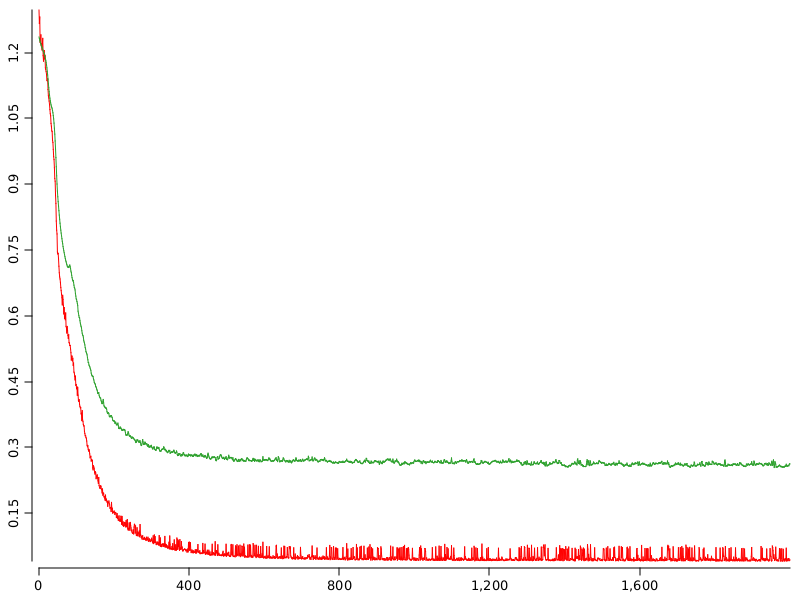

0ef11d52-6b07-4f8f-8c78-d4a97837e4ef

In [11]:
display(WS.image(lines(trainLoss, color(Color.RED), lwd(1)).lines(testLoss, color(2), lwd(1))));